# Processing natural language with Neural Networks

In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Data

Sentiment Analysis

http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!mkdir -p data
!mv aclImdb_v1.tar.gz data/
!cd data && tar zxf aclImdb_v1.tar.gz

--2019-01-11 11:33:21--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  32.4MB/s    in 2.5s    

2019-01-11 11:33:23 (32.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
!du -hs data

2.7G	data


Of all the files included in the data directory, we will focus on the following directories:

The training data:

* train/pos
* train/neg

The test data:

* test/pos
* test/neg

The contents are just text files, and the subdirectories are the corresponding label for the review of the movie. Those will be the labels of our data.

Those text files are small enough to be loaded in memory (~ 50 MB per label and set).

In [5]:
import os

base_dir = 'data/aclImdb/'
datasets = ['train', 'test']
labels = ['neg', 'pos']

# This dictionary will contain two keys, train and test
# Each key will have a dictionary with the texts and the labals
# d -> train -> text
#               y
#      test  -> ... 
d = {}

for dataset in datasets:
    # Init this dataset
    d[dataset] = {'text': [], 'y': []}
    print("Now filling the %s set" % dataset)
    for label in labels:
        print("  Reading the %s reviews" % label)
        k = 1
        y = labels.index(label)  # 0 for neg, 1 for pos
        dataset_dir = base_dir + "/" + dataset + "/" + label
        for fn in os.listdir(dataset_dir):
            d[dataset]['y'].append(y)
            path = dataset_dir + "/" + fn
            # We read each line, and then we keep a string with words separated by spaces
            review_text = " ".join([l.strip() for l in open(path, 'r').readlines()])
            d[dataset]['text'].append(review_text)
            k += 1
            if k % 1000 == 0:
                print("    %d reviews read..." % k)


Now filling the train set
  Reading the neg reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 reviews read...
    12000 reviews read...
  Reading the pos reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 reviews read...
    12000 reviews read...
Now filling the test set
  Reading the neg reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 revi

### Transforming texts into a tensor and limiting the number of words

The text reviews will all have a different length in the general case. We need to force the reviews to have all the same length, or we will not be able to build a tensor out of the text data.

Let's check the distribution of review size (in number of words), to decide on a good number for the limit in review size.

In [0]:
import pandas as pd

In [7]:
train_lengths = np.array([len(c) for c in d['train']['text']])
pd.Series(train_lengths).describe()

count    25000.000000
mean      1325.068600
std       1003.132835
min         52.000000
25%        702.000000
50%        979.000000
75%       1614.000000
max      13704.000000
dtype: float64

Let's choose 1000 words for the reviews.

In [0]:
MAX_WORDS = 1000

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(MAX_WORDS)

In [0]:
# Now we "fit" this tokenizer over our text (e.g. to make sure we use a common vocab. index for all the reviews)
tokenizer.fit_on_texts(d['train']['text'] + d['test']['text'])

In [0]:
# Let's see what the fit process has done
# See the output of the following objects
# tokenizer.word_index
# tokenizer.word_counts

In [0]:
x_train = tokenizer.texts_to_matrix(d['train']['text'])

In [14]:
x_train.shape

(25000, 1000)

In [0]:
x_test = tokenizer.texts_to_matrix(d['test']['text'])

**EXERCISE 1**. What kind of transformation have we done here? 

**EXERCISE 2**. Can you see any problem with this approach? How would you solve it?

**EXERCISE 3**. Do we need to transform the labels? Why? Or why not?

## Building the model

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

In [0]:
import tensorflow as tf

In [0]:
def keras2tpu(m):
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    m,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

  return tpu_model

In [0]:
def build_model_1():
    m = models.Sequential()
    m.add(layers.LSTM(128, return_sequences=True, input_shape=(MAX_WORDS,1)))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(16))
    m.add(layers.Dense(1, activation='sigmoid'))

    return m

In [0]:
def build_model_2():
    m = models.Sequential()    
    m.add(layers.Dense(512, activation='relu', input_shape=(MAX_WORDS,1)))
    m.add(layers.Dense(256, activation='relu'))
    m.add(layers.LSTM(128, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(16))
    m.add(layers.Dense(1, activation='sigmoid'))

    return m

In [21]:
m = keras2tpu(build_model_2())

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.117.15.26:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8233034265213306644)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16959600795833128122)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9373831499842142796)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13991473947809694980)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3260118208508697266)
INFO:tensorflow:*** Available Device: _Device

In [22]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     (None, 1000, 1)           0         
_________________________________________________________________
dense (Dense)                (None, 1000, 512)         1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 256)         131328    
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 128)         197120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 32)          12416     
__________

In [23]:
m.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metrics=[metrics.binary_accuracy])

INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}


In [24]:
h = m.fit(x_train.reshape((25000, MAX_WORDS, 1)), d['train']['y'], epochs=40, batch_size=2048, validation_split=.2)

Train on 25000 samples, validate on 5000 samples
Epoch 1/40
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(256,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(256, 1000, 1), dtype=tf.float32, name='dense_input_10'), TensorSpec(shape=(256, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for dense_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f076e2a4cc0> []
INFO:tensorflow:Started compiling


RuntimeError: ignored

## Performance of the model

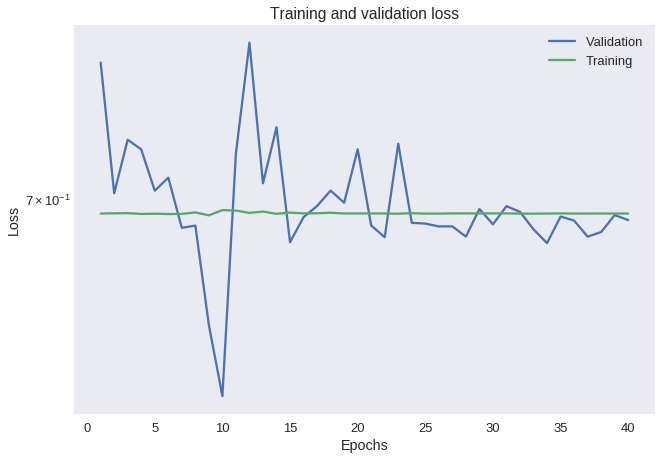

In [0]:
plot_metric(h, 'loss')

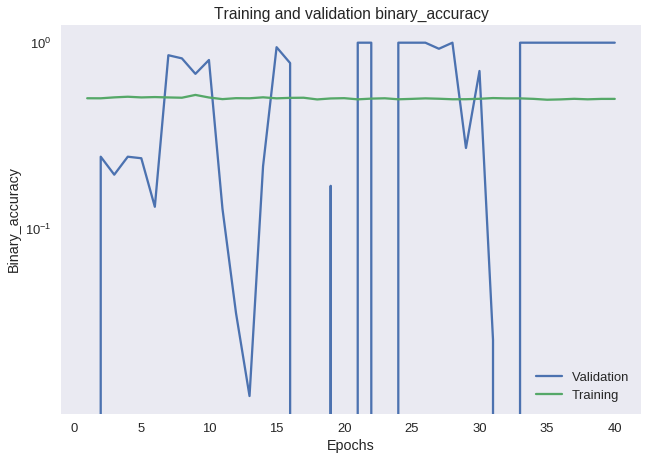

In [0]:
plot_metric(h, 'binary_accuracy')

In [0]:
m.evaluate(x_test.reshape(25000, MAX_WORDS, 1), d['test']['y'])

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(4, 1000, 1), dtype=tf.float32, name='lstm_4_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for lstm_4_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f6354b11a20> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 48.82206702232361 secs
24992/25000 [============================>.] - ETA: 0sINFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(1, 1000, 1), dtype=tf.float32, name='lstm_4_input_10'), TensorSpec(shape=(1, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapp

[0.6931516382598877, 0.5]